## Offline analysis

here we will explore

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
plt.style.use('science')

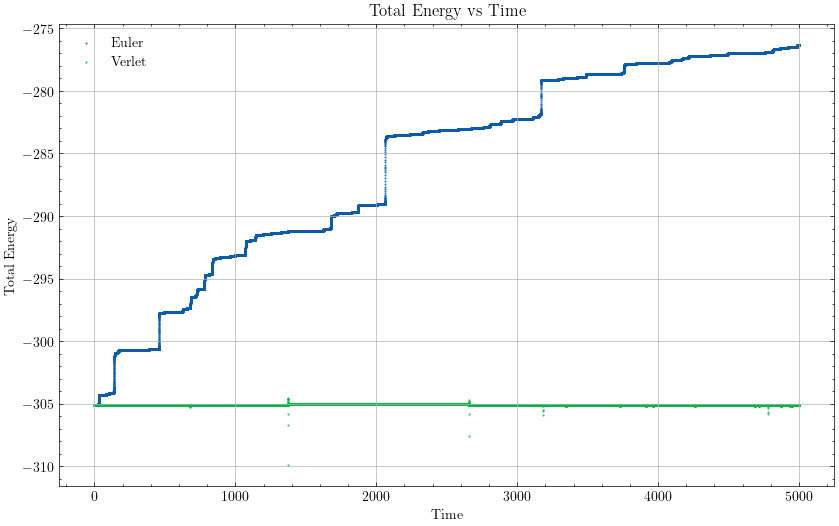

In [13]:
filenameEuler="../data/CPUSequential/energy_N128_Euler.txt"
filenameVerlet="../data/CPUSequential/energy_N128_Verlet.txt"

dataEuler = np.loadtxt(filenameEuler)
time = dataEuler[:,0]
energy = dataEuler[:,3]
kinetic = dataEuler[:,1]
potential = dataEuler[:,2]

dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]

plt.figure(figsize=(10,6))
plt.scatter(time, energy, marker='.', s=0.8, label='Euler')
plt.scatter(time, energyVerlet, marker='.', s=0.8, label='Verlet')
plt.xlabel("Time")
plt.ylabel("Total Energy")
plt.title("Total Energy vs Time")
plt.grid()
plt.legend()
plt.show()

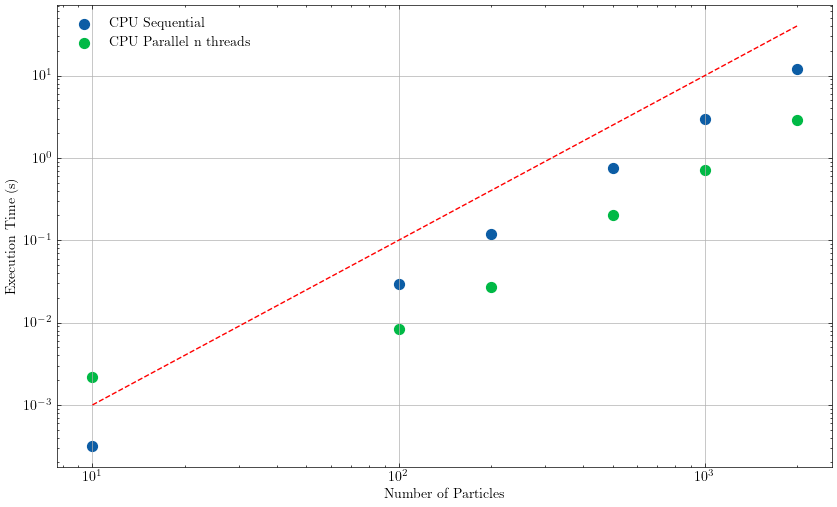

In [22]:
filenameSequential = "../data/CPUSequential/time.dat"
filenameMPI = "../data/CPUParallel/time_16threads.dat"
repetitions = 15

nParticlesSequential = []
timeSequential = []
nParticlesMP = []
timeMP = []

with open(filenameSequential, 'r') as file:
    lines = file.readlines()

for i in range(0, len(lines), repetitions):
    chunk = lines[i:i + repetitions]
    particles_chunk = []
    times_chunk = []
    for line in chunk:
        parts = line.strip().split()
        particles_chunk.append(int(parts[0]))
        times_chunk.append(float(parts[-1]))
    nParticlesSequential.append(particles_chunk[0])
    # Select the minimum time from the repetitions
    timeSequential.append(np.min(times_chunk))

with open(filenameMPI, 'r') as file:
    lines = file.readlines()
for i in range(0, len(lines), repetitions):
    chunk = lines[i:i + repetitions]
    particles_chunk = []
    times_chunk = []
    for line in chunk:
        parts = line.strip().split()
        particles_chunk.append(int(parts[0]))
        times_chunk.append(float(parts[-1]))
    nParticlesMP.append(particles_chunk[0])
    # Select the minimum time from the repetitions
    timeMP.append(np.min(times_chunk))

# Plot them
plt.figure(figsize=(10,6))
plt.scatter(nParticlesSequential, timeSequential, marker='.', s=200, label='CPU Sequential')
plt.scatter(nParticlesMP, timeMP, marker='.', s=200, label='CPU Parallel n threads')
plt.xlabel("Number of Particles")
plt.ylabel("Execution Time (s)")
#reference line
x = np.linspace(np.min(nParticlesSequential), np.max(nParticlesSequential), 100)
ref_time = 1e-5*x**2
plt.plot(x, ref_time,  color='red', linestyle='--')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

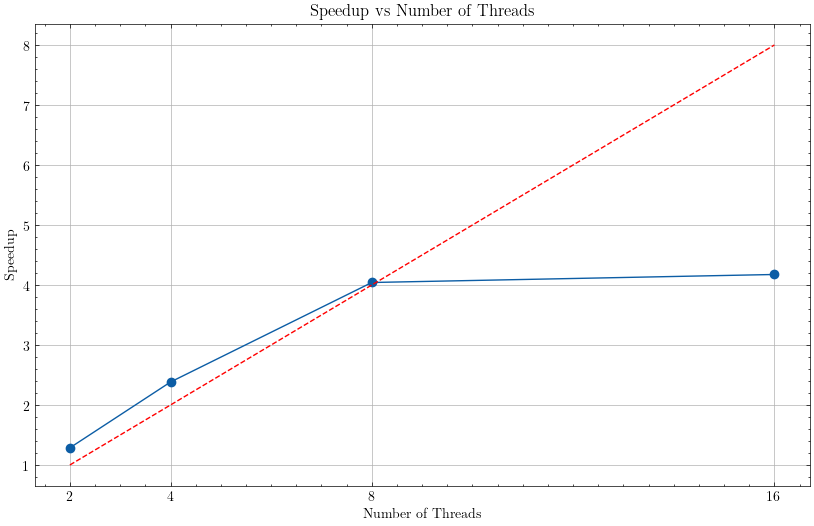

Speedups: [1.286002715065153, 2.3827805047052015, 4.04148069646266, 4.175012105857832]


In [24]:
nthreads = [2,4,8, 16]
speedups = []
# Compute speedup for each nthreads using only the largest nParticles
for n in nthreads:
    filename = f"../data/CPUParallel/time_{n}threads.dat"
    times_nthreads = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    for i in range(0, len(lines), repetitions):
        chunk = lines[i:i + repetitions]
        particles_chunk = []
        times_chunk = []
        for line in chunk:
            parts = line.strip().split()
            particles_chunk.append(int(parts[0]))
            times_chunk.append(float(parts[-1]))
        # We only care about the largest nParticles
        if particles_chunk[0] == max(nParticlesMP):
            times_nthreads.append(np.min(times_chunk))
    # Speedup is sequential time divided by parallel time
    seq_time = timeSequential[-1]  # Last element corresponds to largest nParticles
    par_time = times_nthreads[0]
    speedup = seq_time / par_time
    speedups.append(speedup)
# Plot speedup
plt.figure(figsize=(10,6))
plt.plot(nthreads, speedups, marker='o')
plt.xlabel("Number of Threads")
plt.ylabel("Speedup")
plt.title("Speedup vs Number of Threads")
plt.plot(np.arange(2, max(nthreads)+1), 0.5*np.arange(2, max(nthreads)+1), linestyle='--', color='red', label='Ideal Speedup')
plt.grid()
plt.xticks(nthreads)
plt.show()
print("Speedups:", speedups)